<a href="https://colab.research.google.com/github/Shuao98/TAD_Lab/blob/main/Copy_of_Lab_4_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text as Data Lab 4: Text Classification

In this week's lab, we'll explore basic concepts for building and evaluating a classifier.

The aims of this lab are:
- Building a classifier for a binary classification problem
- Evaluating a classifier with various metrics
- Learning about the uses of the training, validation and test sets

This lab will make use of the [scikit-learn](https://scikit-learn.org) library. This lab won't give you the code directly but will point you towards the documentation for the function to use. **Each scikit-learn function comes with example code in its documentation.** The lab also does not use `labtest` this time but will provide expected answers.

**Before you start, save a copy of this lab to your drive using "File > Save a Copy in Drive".** If you skip this step, you may lose progress that you have made (e.g., if you close the browser tab or your computer crashes).

## The Task: Identifying Clinical Trials

[Clinical trials](https://en.wikipedia.org/wiki/Clinical_trial) test out new treatments for diseases and their results are generally reported in published research articles. Identifying that a paper is talking about a clinical trial is an important step towards gathering all these results together for further analysis.

We'll be looking at the problem of identifying if a biomedical research article is discussing the results of a [clinical trial](https://en.wikipedia.org/wiki/Clinical_trial). Biomedical research articles are indexed in a huge database called [PubMed](https://pubmed.ncbi.nlm.nih.gov/). It tracks the titles & abstracts of almost all biomedical publications along with various other bits of metadata.

## Loading the text classification data



We've created a small subset of these articles that focus on [asthma](https://en.wikipedia.org/wiki/Asthma). Some of the articles are reporting on clinical trials and others are not.

Let's download it:

In [1]:
!wget -O asthma_dataset.json https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/ERJRy93FbypJm4mawO79wwgB1bt9uvuvHQs5gtKRkzXyHg?download=1

--2026-02-10 11:21:52--  https://gla-my.sharepoint.com/:u:/g/personal/jake_lever_glasgow_ac_uk/ERJRy93FbypJm4mawO79wwgB1bt9uvuvHQs5gtKRkzXyHg?download=1
Resolving gla-my.sharepoint.com (gla-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to gla-my.sharepoint.com (gla-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=ddcb51126fc5492a9b899ac0eefdc308 [following]
--2026-02-10 11:21:53--  https://gla-my.sharepoint.com/personal/jake_lever_glasgow_ac_uk/_layouts/15/download.aspx?UniqueId=ddcb51126fc5492a9b899ac0eefdc308
Reusing existing connection to gla-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1675650 (1.6M) [application/json]
Saving to: ‘asthma_dataset.json’

asthma_dataset.json 100%[===================>]   1.60M  3.06MB/s    in 0.5s    

2026-02-10 11:21:54 

It's a JSON file. We can use the Unix `head` command to look inside the file. As the file is nicely formatted, we can see that it is a set of records with four fields: `is_clinical_trial`, `pubmed_id`, `title` and `abstract`.

In [2]:
!head asthma_dataset.json

[
  {
    "is_clinical_trial": true,
    "pubmed_id": 346628,
    "title": "Immunotherapy in cat-induced asthma. Double-blind trial with evaluation of bronchial responses to cat allergen and histamine.",
    "abstract": "Ten asymptomatic patients with normal pulmonary function were selected for a double-blind trial of immunotherapy in cat-induced asthma. Each patient had a positive prick test to cat pelt extract and also a positive bronchial challenge response to the same extract. Patients were randomly assigned to active treatment or placebo groups and received weekly or biweekly injections over a 3 to 4-month period. The 5 patients who received the active treatment received a cumulative dose of cat pelt extract that ranged from 16.4 to 44.8 mg of total solid containing 1.7 to 4.7 mg of cat allergen 1. Apparent systemic reactions were observed in 3 patients who received the placebo and 3 patients who received the active treatment. The 5 patients who received the active treatment showe

### Exploring the data

Let's get this data loaded and start looking at it.

**Exercise:** Load the `asthma_dataset.json` into a variable called `documents` and check how many documents are in the dataset.

In [4]:
# your code!
import json

# Load the dataset
with open("asthma_dataset.json", "r", encoding="utf-8") as f:
    documents = json.load(f)

# Check how many documents are in the dataset
num_documents = len(documents)

print(f"Number of documents: {num_documents}")

Number of documents: 1021


You should see that there are 1021 documents.

Let's take a look at the first couple of documents. The first document is a clinical trial and even mentions it in the title. The second article is about asthma but is about the cost of treatment. Could the word `trial` be enough to identify papers talking about clinical trials?

In [5]:
documents[:2]

[{'is_clinical_trial': True,
  'pubmed_id': 346628,
  'title': 'Immunotherapy in cat-induced asthma. Double-blind trial with evaluation of bronchial responses to cat allergen and histamine.',
  'abstract': 'Ten asymptomatic patients with normal pulmonary function were selected for a double-blind trial of immunotherapy in cat-induced asthma. Each patient had a positive prick test to cat pelt extract and also a positive bronchial challenge response to the same extract. Patients were randomly assigned to active treatment or placebo groups and received weekly or biweekly injections over a 3 to 4-month period. The 5 patients who received the active treatment received a cumulative dose of cat pelt extract that ranged from 16.4 to 44.8 mg of total solid containing 1.7 to 4.7 mg of cat allergen 1. Apparent systemic reactions were observed in 3 patients who received the placebo and 3 patients who received the active treatment. The 5 patients who received the active treatment showed a reduction 

It's a good idea to dig around in the data to see if there are any oddities. Maybe some documents are missing titles or abstracts? Or could there be whole documents in there? It's always good to know these things.

**Exercise:** Find out the minimum and maximum lengths of the `abstract` field across all the documents

In [7]:
# your code!
abstract_lengths = [
    len(doc["abstract"])
    for doc in documents
    if "abstract" in doc and doc["abstract"] is not None
]

# Compute min and max
min_length = min(abstract_lengths)
max_length = max(abstract_lengths)

print(f"Minimum abstract length: {min_length}")
print(f"Maximum abstract length: {max_length}")


Minimum abstract length: 161
Maximum abstract length: 4140


You should see that the minimum length is 161 characters and maximum is 4140 characters. That's quite a spread. From a tweet up to a short essay.

Now it's time to prepare the data for the classification task. Let's create two lists to separate the target labels (`is_clinical_trial`) from the text field that we'll use. The two lists are called `labels` and `texts`. We'll combine the `title` and `abstract` field like we did for the Reddit data in previous labs.

In [12]:
labels, texts = [], []

for doc in documents:
  labels.append(doc['is_clinical_trial'])
  texts.append(doc['title'] + '\n' + doc['abstract'])

And let's check what the distribution of labels is:

In [13]:
from collections import Counter
Counter(labels)

Counter({True: 327, False: 694})

You should see that there are 327 True labels and 694 False labels.

### Split the data into training, validation and testing datasets

As discussed in the lecture, we need to split the dataset into parts to train and parts to evaluate. This is known as **cross-validation**. Let's split our dataset of 1021 `labels` and `texts` into training, validation and test splits.

**Exercise:** Use scikit-learn's [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split the dataset into three parts using a 60%/20%/20% split for training, validation and testing respectively. You'll need to call [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) twice. First to split the `labels` and `texts` into 80%/20% to get the train+val and the test set. Then call it again on the train+val with a 75%/25% split. You'll want to use the `test_size` parameter and use `random_state=42` to get the same results as everyone else.

The six outputs should be called `texts_train`, `labels_train`, `texts_val`, `labels_val`, `texts_test` and `labels_test`.

In [16]:
# your code!
from sklearn.model_selection import train_test_split

# 1) Split into train+val (80%) and test (20%)
texts_train_val, texts_test, labels_train_val, labels_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42
)

# 2) Split train+val into train (75% of 80% = 60%) and val (25% of 80% = 20%)
texts_train, texts_val, labels_train, labels_val = train_test_split(
    texts_train_val,
    labels_train_val,
    test_size=0.25,
    random_state=42
)


Let's check the size of the different parts after the split.

In [17]:
print(f"{len(texts_train)=}\t{len(labels_train)=}")
print(f"{len(texts_val)=}\t{len(labels_val)=}")
print(f"{len(texts_test)=}\t{len(labels_test)=}")

len(texts_train)=612	len(labels_train)=612
len(texts_val)=204	len(labels_val)=204
len(texts_test)=205	len(labels_test)=205


You should see that the dataset has been split into parts with sizes 612, 204 and 205. And that the corresponding `texts_*` and `labels_*` parts are the same sizes.

And let's check if we got the desired 60%/20%/20% split.

In [18]:
total = len(texts_train) + len(texts_val) + len(texts_test)
len(texts_train)/total, len(texts_val)/total, len(texts_test)/total

(0.5994123408423114, 0.19980411361410383, 0.2007835455435847)

Yep, that's probably as close as we could get to 60%/20%/20% when splitting up 1021 documents.

### Why training, validation and testing?

As mentioned in the lectures, we want part of the data to build a classifier and part to evaluate with. So why not just training and test? Using a validation set allows us to try a lot more experiments to test out different approaches without the worry that we're overfitting on the test set.

Good practice is to avoid touching the test set until your final set of experiments. We'll forget about the test data until the end of the lab and use the training and validation splits for now.

## Build your own classifier

Earlier, we noticed that the word "trial" appeared in the first document talking about clinical trials. Maybe the existence of the word "trial" would be enough to identify clinical trials?

**Exercise:** Iterate over the validation set `texts_val` and check if the string "trial" appears in each text. Save the prediction (which should be `True` or `False`) to a list called `labels_predicted`. You do not need to do any parsing. You can use the string [count](https://www.w3schools.com/python/ref_string_count.asp) method.

In [19]:
# your code!
labels_predicted = []

for text in texts_val:
    # Check if the word "trial" appears anywhere in the text
    prediction = text.count("trial") > 0
    labels_predicted.append(prediction)


Let's check how many predictions of each label we have using a `Counter`:

In [20]:
Counter(labels_predicted)

Counter({False: 176, True: 28})

You should have 176 False predictions and 28 True Predictions (totalling 204 for the size of the validation set).

**Congratulations!** You have written a machine learning classifier. It may be a simple rule-based approach but sometimes simple is all you need. This type of classifier is known as a [decision stump](https://en.wikipedia.org/wiki/Decision_stump) where a single decision is used to classify the data.

But is it any good?

#### Evaluate your own classifier

Now let's compare our predictions `labels_predicted` against the actual labels `labels_val`. We'll need the four numbers that make up a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for a binary classification problem:

- True positive count: Where the actual label is True and predicted label is True
- False positive count: Where the actual label is False and predicted label is True
- False negative count: Where the actual label is True and predicted label is False
- True negative count: Where the actual label is False and predicted label is False

**Exercise:** Calculate the counts of true positives, false positives, false negatives and true negatives when comparing `labels_predicted` and `labels_val`.

*Tip:* Python's [zip function](https://docs.python.org/3.3/library/functions.html#zip) is useful for this.

In [21]:
# your code!
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0

for pred, actual in zip(labels_predicted, labels_val):
    if actual is True and pred is True:
        true_positive += 1
    elif actual is False and pred is True:
        false_positive += 1
    elif actual is True and pred is False:
        false_negative += 1
    elif actual is False and pred is False:
        true_negative += 1

print("True positives:", true_positive)
print("False positives:", false_positive)
print("False negatives:", false_negative)
print("True negatives:", true_negative)


True positives: 20
False positives: 8
False negatives: 52
True negatives: 124


You should get 20 true positives, 8 false positives, 52 false negatives and 124 true negatives. So it does identify quite a few documents correctly as describing clinical trials but misses many more.

The raw counts of a confusion matrix can be a little challenging to comprehend. It gets harder if you want to compare multiple classifier results. Let's turn the counts into some of the standard metrics we will use:

- $ accuracy = \frac{TP+TN}{TP+FP+FN+TN} $

- $ precision = \frac{TP}{TP+FP} $

- $ recall = \frac{TP}{TP+FN} $

- $ F_1 = 2\frac{precision \times recall}{precision + recall} $

**Exercise:** Calculate the $accuracy$, $precision$, $recall$ and $F_1 score$ with the confusion matrix counts to 3 decimal places.

*Tip:* You can output a number nicely using [f-strings](https://docs.python.org/3/tutorial/inputoutput.html#formatted-string-literals). To output the variable `x` to 5 decimal places, you could use `print(f"{x:.5f}")`

In [23]:
# your code!
accuracy = (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")

Accuracy:  0.706
Precision: 0.714
Recall:    0.278
F1 score:  0.400


You should get accuracy=0.706, precision=0.714, recall=0.278 and f1=0.400. The precision is on the higher end as it doesn't predict too many false positives, but the recall is low as there are many false negatives.

*Bonus tip:* practically you only want to give a few decimal places when reporting results. It can look odd to give 10 decimal places, and it can make the numbers more challenging to read. The numbers at the 5th and 6th decimal place are likely not very important. Three decimal places are often sufficient.

Scikit-learn offers some useful functions to calculate the confusion matrix counts as well as the different evaluation metrics directly.

**Exercise:** Use scikit-learn's [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to calculate the true positive, false positive, false negative and true negative counts of the actual labels `labels_val` and the predicted labels `labels_predicted` from above. The counts should be the same as you calculated earlier

In [24]:
# your code!
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels_val, labels_predicted)

print(cm)


[[124   8]
 [ 52  20]]


Now let's get the evaluation metrics with scikit-learn.

**Exercise:** Use [scikit-learn metrics functions](https://scikit-learn.org/stable/modules/model_evaluation.html) to calculate the accuracy, precision, recall and f1 scores of our earlier predictions `labels_predicted` against the actual labels `labels_val`.

In [26]:
# your code!
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(labels_val, labels_predicted)
precision = precision_score(labels_val, labels_predicted)
recall = recall_score(labels_val, labels_predicted)
f1 = f1_score(labels_val, labels_predicted)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")


Accuracy:  0.706
Precision: 0.714
Recall:    0.278
F1 score:  0.400


You may want to make a figure from the confusion matrix. Scikit-learn offers a function [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) that displays the confusion matrix.

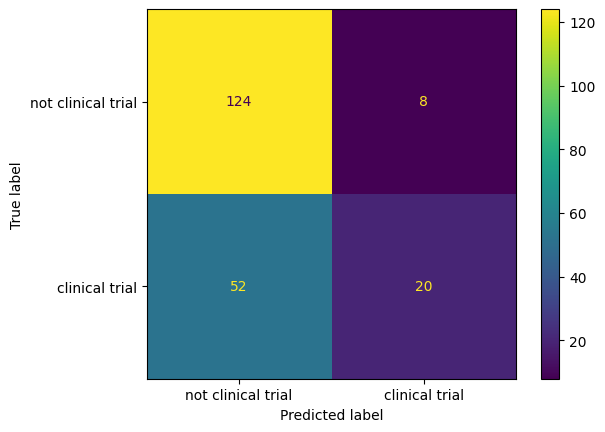

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(labels_val, labels_predicted)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not clinical trial','clinical trial']).plot()

It can be nice to have a bit more control over the plotting. Here's some code using a plotting library called [seaborn](https://seaborn.pydata.org/) that outputs a labeled confusion matrix. It allows you to use a custom colour palette including [ColorBrewer](https://colorbrewer2.org/) which is commonly used for making nice plots. Here we use the `Reds` palette, but there are [many more](https://seaborn.pydata.org/tutorial/color_palettes.html). Some are recommended for colour-blind audiences or for printing.

<Axes: xlabel='Predicted', ylabel='Actual'>

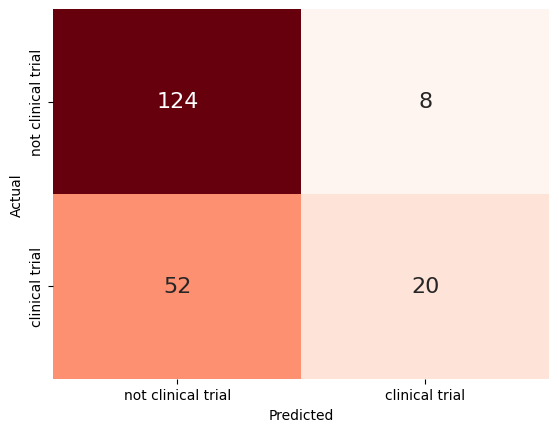

In [28]:
import seaborn as sn

def plotConfusionMatrix(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Reds", as_cmap=True)
  labels = ['not clinical trial', 'clinical trial']
  plot = sn.heatmap(cm,
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels, # Put in the X and Y labels
                    yticklabels=labels)
  plot.set(xlabel='Predicted', ylabel='Actual')
  return plot

plotConfusionMatrix(labels_val, labels_predicted)

*Extra tip:* Scikit-learn also has a nice function [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) which is useful for multi-class classification problems. It's not as useful for binary problems.

### Building a dummy classifier

We got an accuracy of 0.706. Is that good? Well, it depends on the class balance, which in this dataset is the balance of positive and negative labels.

At the beginning, we calculated the label counts for the whole dataset and know that the negatives are in the majority. What if the classifier always predicted False?

**Exercise:** Make another classifier (not using scikit-learn) that always predicts False for every sample in the validation set. Store the result to `labels_predicted` again.

In [29]:
# your code!
labels_predicted = [False for _ in texts_val]

# Optional sanity check
print("Number of predictions:", len(labels_predicted))
print("First 10 predictions:", labels_predicted[:10])

Number of predictions: 204
First 10 predictions: [False, False, False, False, False, False, False, False, False, False]


**Exercise:** Calculate the accuracy of these new predictions using scikit-learn. *Tip:* copy your scikit-learn code from above

In [31]:
# your code!
accuracy = accuracy_score(labels_val, labels_predicted)
accuracy

0.6470588235294118

Huh, the accuracy of always predicting False is 0.647. So 0.704 is better, but not by that much.

Where does the 0.647 come from?

**Exercise:** Calculate the percentage of False labels in `labels_val`. You could use a [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) again or you can use [sum](https://docs.python.org/3/library/functions.html#sum) to add up lists of boolean values.

In [32]:
# your code!
# Count how many labels are False
num_false = labels_val.count(False)

# Total number of labels
total = len(labels_val)

# Percentage of False labels
percent_false = (num_false / total) * 100

print(f"Percentage of False labels: {percent_false:.2f}%")

Percentage of False labels: 64.71%


The accuracy score matches the majority class percentage. So, for really extreme class imbalances (like 1% positive labels), guessing the most frequent class will get you a very high accuracy score - which is not helpful. That's why we need to use other metrics like precision, recall and F1.

*Extra tip:* Scikit-learn offers a [dummy classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that can use basic strategies like guessing the most frequent class. This can provide a baseline to compare other scores against.

**Exercise:** Now calculate the precision, recall and F1 scores of these new predictions `labels_predicted` against the actual labels `labels_val` using scikit-learn functions. *Tip:* Copy your code again from above.

In [33]:
# your code!
precision = precision_score(labels_val, labels_predicted)
recall = recall_score(labels_val, labels_predicted)
f1 = f1_score(labels_val, labels_predicted)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")

Precision: 0.000
Recall:    0.000
F1 score:  0.000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Wow, zeros for precision, recall and F1. This is not a good classifier even though the accuracy looked okay.

Notice the warning about precision being ill-defined. If the denominators in the equations for precision, recall or F1 are zero, you have a divide by zero and the metric is not defined. Scikit-learn will still return a zero, but you may get a warning.

## Train a scikit-learn classifier

Now, we've created our own classifier that looked for the word `trial` and a dummy classifier that always predicted the most frequent class. Let's create an actual classifier based on the word frequencies in the documents.

First, we want to vectorise the documents and turn each one into a TF-IDF vector. This will give us feature matrices that we can use for our classifiers.

**Exercise:** Fit a [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to the training text (`texts_train`), transform the training text and the validation text. Use the default parameters for TfidfVectorizer. You may want to check previous labs for using TfidfVectorizer. Output the matrix dimensions (`.shape`) of the vectorised training and validation texts.

In [34]:
# your code!
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training text and transform the training data
X_train = vectorizer.fit_transform(texts_train)

# Transform the validation text using the same vectorizer
X_val = vectorizer.transform(texts_val)

# Output the matrix dimensions
print("Training matrix shape:", X_train.shape)
print("Validation matrix shape:", X_val.shape)


Training matrix shape: (612, 9321)
Validation matrix shape: (204, 9321)


You should have a training dataset with dimensions (612,9321) and a validation feature matrix with dimensions (204, 9321).

We've got the feature matrices that we need to train a scikit-learn classifier. We'll look at one of the standard ones: Logistic Regression.

**Exercise:** Fit a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier to the training feature matrix (that you got from the TfidfVectorizer) and the training labels (`labels_train`). Then make predictions on the validation data (using its feature matrix). Save the predictions to the `labels_predicted` variable and check its length. Use the defaults with a `random_state=42`.

In [35]:
# your code!
from sklearn.linear_model import LogisticRegression

# Initialize the classifier
clf = LogisticRegression(random_state=42)

# Fit on training data
clf.fit(X_train, labels_train)

# Make predictions on the validation data
labels_predicted = clf.predict(X_val)

# Check the length of predictions
print("Number of predictions:", len(labels_predicted))


Number of predictions: 204


You should have 204 predictions that matches the size of the validation set.

Let's see what the confusion matrix of our new predictions `labels_predicted` with Logistic Regression looks like:

<Axes: xlabel='Predicted', ylabel='Actual'>

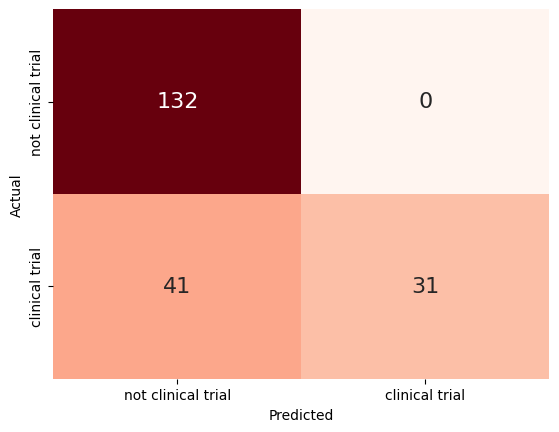

In [36]:
plotConfusionMatrix(labels_val, labels_predicted)

You should see 132 true negatives, 0 false positives, 41 false negatives and 31 true positives.

**Exercise:** Now we know that accuracy isn't good for this dataset, calculate the precision, recall and F1 scores to three decimal places.

In [38]:
# your code!
precision = precision_score(labels_val, labels_predicted)
recall = recall_score(labels_val, labels_predicted)
f1 = f1_score(labels_val, labels_predicted)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 score:  {f1:.3f}")

Precision: 1.000
Recall:    0.431
F1 score:  0.602


That's great precision! All of the documents it predicts to be clinical trial reports are. The recall is on the lower end though.

### Evaluating on the training set

The most useful evaluation metrics are on a **held-out** dataset - one which was not used for training the classifier. However, it is sometimes useful to see how the classifier performs on the training set. If it performs very very well on the training set, and much worse on the validation set, it is likely that the classifier has [overfit](https://en.wikipedia.org/wiki/Overfitting) the training set. This can depend on the specific algorithm of the classifier

Let's check out the performance metrics on the training set.

**Exercise:** Use the existing classifier to make predictions on the training vectors and calculate the precision, recall and F1 scores against the training labels `labels_train`.

In [39]:
# your code!
labels_pred_train = clf.predict(X_train)

# Calculate metrics
precision_train = precision_score(labels_train, labels_pred_train)
recall_train = recall_score(labels_train, labels_pred_train)
f1_train = f1_score(labels_train, labels_pred_train)

print(f"Training Precision: {precision_train:.3f}")
print(f"Training Recall:    {recall_train:.3f}")
print(f"Training F1 score:  {f1_train:.3f}")

Training Precision: 0.984
Training Recall:    0.651
Training F1 score:  0.784


You should see training precision=0.984, training recall=0.651 and training f1=0.784. The F1 score is higher on the training set than the validation set so some amount of overfitting is likely happening. Note that the classifier performance will almost always be better on the training set than the validation set.

## Trying out different pipelines

We've got one machine learning pipeline (from text data, to vectorised data, to a classifier and to predictions). We now want to try out some other pipelines and see if we can make any improvements.

### Using spaCy for tokenization

We used the defaults for the TfidfVectorizer before. One of those defaults is how to do the tokenization. The TfidfVectorizer uses a fairly basic technique to split up text into tokens. Let's see if using spaCy improves anything.

Below is code from a previous lab to tokenize text using spaCy.

In [40]:
import spacy

nlp = spacy.load('en_core_web_sm')

def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

# Example usage:
text_pipeline_spacy("Of all the things I miss, I miss my mind the most.")

['thing', 'miss', 'miss', 'mind']

**Exercise:** Run the machine learning pipeline again using this new tokenization - essentially copy the various steps of scikit-learn from above and change the TfidfVectorizer. Specifically: vectorise the training and validation data with a [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) that uses the `text_pipeline_spacy` function as its tokenizer. Train a new LogisticRegression classifier on the training labels and new training feature matrix. Make predictions on the validation set and calculate the F1-score. As before, use `random_state=42` and no other parameters for LogisticRegression

This may take a minute to run.

In [41]:
# your code!
# 1) Vectorize with custom spaCy tokenizer
vectorizer_spacy = TfidfVectorizer(tokenizer=text_pipeline_spacy)

# Fit on training text and transform both training and validation
X_train_spacy = vectorizer_spacy.fit_transform(texts_train)
X_val_spacy = vectorizer_spacy.transform(texts_val)

# 2) Train Logistic Regression
clf_spacy = LogisticRegression(random_state=42)
clf_spacy.fit(X_train_spacy, labels_train)

# 3) Make predictions on validation set
labels_predicted_spacy = clf_spacy.predict(X_val_spacy)

# 4) Calculate F1 score
f1_spacy = f1_score(labels_val, labels_predicted_spacy)

print(f"F1 score with spaCy tokenizer: {f1_spacy:.3f}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score with spaCy tokenizer: 0.629


You should get an F1 score of 0.629 so slightly better with this tokenization strategy.

### Changing the hyperparameters

Looking at the scikit-learn pages for the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) and [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), there are a lot of options you can tweak that will affect how the classifier behaves. These are known as hyperparameters. Let's try out a different setting. The `C` hyperparameter of a Logistic Regression classifier controls a feature known as [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)). This can stop a classifier from overfitting by limiting the weights that the classifier puts on different individual features. A higher `C` lowers the amount of regularization.

**Exercise:** Run the machine learning pipeline (vectorizing, building classifier and making predictions) with a TfidfVectorizer using its default tokenization (no spaCy) and the LogisticRegression with parameter `C=5` and `random_state=42`. Calculate the F1-score of the predictions on the validation dataset.

In [42]:
# your code!
# 1) Vectorize using default TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)

# 2) Initialize Logistic Regression with C=5
clf = LogisticRegression(C=5, random_state=42)
clf.fit(X_train, labels_train)

# 3) Make predictions on validation set
labels_predicted = clf.predict(X_val)

# 4) Calculate F1-score
f1_val = f1_score(labels_val, labels_predicted)

print(f"F1-score with C=5: {f1_val:.3f}")

F1-score with C=5: 0.752


You should get an F1 score of 0.752. Even better!

### Tuning the hyperparameters

There are a lot of hyperparameters that can be tweaked. It is standard practice to try out a bunch of hyperparameter settings with training on the training set and evaluating on the validation set.

Searching across all possible settings (given lists of each possible desired setting for each hyperparameter) is known as [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization).

Scikit-learn provides a nice feature known as [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) that allows you to list the possible settings for each hyperparameter and to then iterate over the different settings. The code below illustrates it for two imagined hyperparameters `a` and `b`.

In [43]:
from sklearn.model_selection import ParameterGrid
param_grid = {'a': [1, 2], 'b': [True, False]}

for params in ParameterGrid(param_grid):
    print(params)

{'a': 1, 'b': True}
{'a': 1, 'b': False}
{'a': 2, 'b': True}
{'a': 2, 'b': False}


Practically the number of possible settings may be so vast that the computational cost of trying them all using grid search is infeasible. You would likely pick a small number of hyperparameters that are known to have a big effect and also choose a limited set of possible values for them.

You may also try a strategy other than grid search, such as optimising one hyperparameter at a time before moving onto the next or some form of random search. There are many strategies for this problem known as [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization). But for now, we'll stick with grid search.

**Exercise:** Using a [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html), try out different settings for the `C` for Logistic Regression (try 1 or 10) and `max_df` for TfidfVectorizer (try 0.7 or 1.0). Again, don't use spaCy for tokenization (for speed) and use `random_state=42` for the Logistic Regression classifier. Save the hyperparameter settings that give the highest F1 score on the validation set.

In [44]:
# your code!
from sklearn.model_selection import ParameterGrid

# Define the grid of hyperparameters
param_grid = {
    "C": [1, 10],
    "max_df": [0.7, 1.0]
}

best_f1 = 0
best_params = {}

# Loop over all combinations
for params in ParameterGrid(param_grid):
    # 1) Vectorize with given max_df
    vectorizer = TfidfVectorizer(max_df=params['max_df'])
    X_train = vectorizer.fit_transform(texts_train)
    X_val = vectorizer.transform(texts_val)

    # 2) Train Logistic Regression with given C
    clf = LogisticRegression(C=params['C'], random_state=42)
    clf.fit(X_train, labels_train)

    # 3) Make predictions on validation set
    labels_pred = clf.predict(X_val)

    # 4) Calculate F1-score
    f1 = f1_score(labels_val, labels_pred)

    # 5) Track the best parameters
    if f1 > best_f1:
        best_f1 = f1
        best_params = params

print(f"Best F1-score: {best_f1:.3f}")
print(f"Best hyperparameters: {best_params}")

Best F1-score: 0.793
Best hyperparameters: {'C': 10, 'max_df': 0.7}


You should find that the settings (`C=10` and `max_df=0.7`) gives the best validation F1 score of 0.793.

We've only tested out a LogisticRegression classifier. It's a good idea to try out a few other classifiers. Scikit-learn offers a large selection of classifier algorithms.

**Exercise:** Pick another classifier from scikit-learn such as a K Nearest Neighbors Classifier, a Linear Support Vector classifier, a Random Forest classifier. Rerun the machine learning classifier with it and see how it performs on the validation set by calculating the F1 score.

In [50]:
# your code!
from sklearn.ensemble import RandomForestClassifier

# 1) Vectorize using default TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_val = vectorizer.transform(texts_val)

# 2) Initialize Random Forest classifier
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, labels_train)

# 3) Make predictions on the validation set
labels_pred_rf = clf_rf.predict(X_val)

# 4) Calculate F1-score
f1_rf = f1_score(labels_val, labels_pred_rf)

print(f"F1-score with Random Forest: {f1_rf:.3f}")


F1-score with Random Forest: 0.829


### Error analysis

As we're trying to squeeze more performance out of our machine learning pipeline, this is also a good time to understand what errors are happening. Essentially, what is our best classifier good at, and what is it not good at? This can lead us to create new custom features, annotate more specific data or other strategies to solve problems.

A good practice is to randomly select some false positives and false negatives (the mistakes) from the validation set and to manually check why they are mistakes. This may require expert knowledge of the text (as in the case of clinical trial reports). Some common outcomes of this analysis:
- The useful features that you can see when you look at the text are not being captured by the features (maybe trigrams are essential)
- The class is so rare that the classifier is having a hard time distinguishing it from the majority class.
  - More data may be required - or other tricks to deal with class imbalance.
- They are not mistakes and the labels are wrong
- The classifier has a problem with certain types of data
  - For the clinical trial reports, there could a type of trial that is described completely differently from others

For multiclass problems, the confusion matrix can also tell you what classes are being confused with others.

We won't dive into the data to do error analysis in this lab.


## Evaluating on the test set

At the end of a machine learning project, when you have done all your experiments on the training & validation sets, it is finally time to turn to the **test set**. You shouldn't use it in training and tuning your model. It should only be used for evaluation and the less you use it the better.

For this lab, don't worry about rerunning things on the test set.

**Exercise:** Take your best pipeline (vectoriser & classifier) approach from above. Train it on the training data and evaluate it on the test data (`texts_test` and `labels_test`). Calculate the Precision, Recall, and F1 score on the test set.

In [52]:
# your code!
vectorizer = TfidfVectorizer(max_df=0.7)
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

# 2) Train Logistic Regression with best C
clf = LogisticRegression(C=10, random_state=42)
clf.fit(X_train, labels_train)

# 3) Make predictions on the test set
labels_pred_test = clf.predict(X_test)

# 4) Calculate Precision, Recall, and F1-score
precision_test = precision_score(labels_test, labels_pred_test)
recall_test = recall_score(labels_test, labels_pred_test)
f1_test = f1_score(labels_test, labels_pred_test)

print(f"Test Precision: {precision_test:.3f}")
print(f"Test Recall:    {recall_test:.3f}")
print(f"Test F1-score:  {f1_test:.3f}")

Test Precision: 0.913
Test Recall:    0.667
Test F1-score:  0.771


You may have found a higher performing classifier so your result may differ. If you used a LogisticRegression classifier with the best parameters from earlier (`C=10` and `max_df=0.7`), you should see an F1 score of 0.771.

You can use the `plotConfusionMatrix` function again to plot your test results (if your predictions are again stored in `labels_predicted`).

<Axes: xlabel='Predicted', ylabel='Actual'>

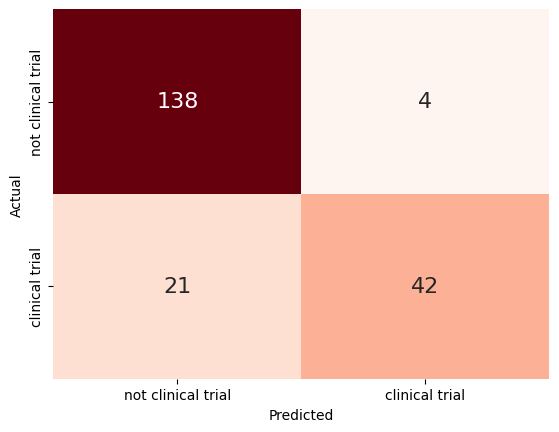

In [55]:
# plotConfusionMatrix(labels_test, labels_predicted)
plotConfusionMatrix(labels_test, labels_pred_test)

## Deployment?

**Congratulations!** We've built a system that can do a good job at identifying articles that discuss clinical trials. You have built a classifier on a training set, tuned it with a validation set and finally evaluated it on a test set.

We would now need to decide if the performance of the classifier is good enough to deploy. This will depend on the specific project and users of the system.

Remember that for the clinical trials project, we aim to identify articles that the authors may have forgotten to tag as a clinical trial. Whether or not our system is suitable for deployment depends on how it will be used. For instance:
 - If we aim to automatically extend a database of clinical trials, we would want to be sure that the data that is inserted is very likely to be about a clinical trial. Otherwise, our database will become unreliable and reduce its utility. In this case, having a system that is high precision, say above 0.9 is desirable. Even if we miss some (i.e., have a lower recall), that might be alright because the alternative is missing these untagged articles anyway. But we'd still probably want reasonable recall (maybe > 0.5), otherwise it may not be worth the cost of deploying and maintaining the model.
 - If we instead aim to have a comprehensive list of clinical trial articles, high recall is critical. In this case, maybe we would target recall of at least 0.99, but acknowledge the fact that precision may suffer to achieve such recall. To counteract this, we would need to consider including a human in the loop to review the classified articles. To reduce human effort, we would want as high precision as possible while maintaining our target level of recall.

For a trained model, these trade-offs can be made by adjusting the decision threshold. The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) or [precision-recall curve](https://www.geeksforgeeks.org/precision-recall-curve-ml/) may be helpful for this. You can explore this topic as an Optional Extra below.

## End

This is the end of Lab 4. Let us know if you encounter any issues! Remember we are here to help!

In this lab, you...
- split your dataset into training, validation and testing sets for good experimental practice
- built a single classifier using a single `if` statement
- evaluated your classifier using the standard classification metrics: accuracy, precision, recall and F1
- used scikit-learn to build a classifier
- tuned hyperparameters to improve performance while evaluating on the validation dataset
- learnt that the test set should only be used for final evaluation, and not ever for tuning your approach

**Please submit your lab through Moodle. We don't mark the labs but it helps us to craft better labs in the future**

## Optional Extras

- The standard spaCy model is good for "normal" English but may not be the best for scientific English. There is a science-version of spaCy, known as [scispacy](https://allenai.github.io/scispacy/). Try out the `en_core_sci_sm` model from [scispacy](https://allenai.github.io/scispacy/). You'll need to install scispacy and the model.
- See how well only using the title performs
- Try out other hyperparameters, such as bigrams from the vectoriser.
- Construct and explore a [Receiver Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [precision-recall curve](https://www.geeksforgeeks.org/precision-recall-curve-ml/) for your model, and think about their use for the two deployment settings discussed above. You'll need to get probabilities from your classifier and not just binary predictions. You'll want the `.predict_proba(...)` classifier function along with the [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) functions. You then need to plot it. Here's some info on [line plotting with Matplotlib](https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html).
- If you're game for it, do the error analysis, look at some mistakenly misclassified documents and see if you can spot any patterns. If you do, let us know!